In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# LED 8

In [2]:
led8_df = pd.read_csv("outLED8.csv")

In [3]:
led8_df['session_type'].unique() # use session_type 1

# s85 = led8_df[led8_df['session_type'] == 85484]
# len(s85)
led8_df['training_level'].unique() # use training_level 16

led8_df['repeat_trial'].unique() # use repeat_trial 0 or 2 or missing

led8_df['LED_trial'].unique() # use animal 85


array([nan])

In [4]:
df = led8_df[(led8_df['session_type'] == 1) & (led8_df['training_level'] == 16) & (led8_df['repeat_trial'].isin([0,2]) | led8_df['repeat_trial'].isna()) ]

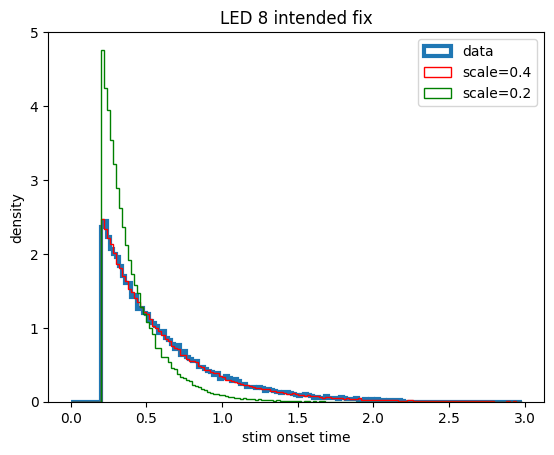

In [5]:
plt.hist(df['intended_fix'], bins=np.arange(0, 3,0.02), density=True, histtype='step', label='data', lw=3)

s_p4 = np.random.exponential(scale=0.4, size=100000) + 0.2
s_p2 = np.random.exponential(scale=0.2, size=100000) + 0.2

plt.hist(s_p4, bins=np.arange(0, 3,0.02), density=True, histtype='step', color='r', label='scale=0.4')
plt.hist(s_p2, bins=np.arange(0, 3,0.02), density=True, histtype='step', color='g', label='scale=0.2')
plt.title('LED 8 intended fix')
plt.xlabel('stim onset time')
plt.ylabel('density')
plt.legend()
plt.show()

# LED 7

In [6]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('out_LED.csv')

In [7]:
# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ].copy()

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [8]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [9]:
# led_trial = 0 in df
df_1 = df [ df['LED_trial'] == 1 ]
df_0 = df [ df['LED_trial'] == 0 ]

# psychometric to see bias

In [10]:
df_0_valid = df_0[df_0['success'].isin([1,-1])]

df_0_valid_less_than_1 = df_0_valid[df_0_valid['timed_fix'] - df_0_valid['intended_fix'] < 1]

In [11]:
df_0_valid_less_than_1.loc[:, 'response_poke'] = 2*df_0_valid_less_than_1['response_poke'] - 5

In [12]:
df_0_valid_less_than_1['correct'] = ((df_0_valid_less_than_1['response_poke'] * df_0_valid_less_than_1['ILD']) > 0).astype(int)

/tmp/ipykernel_60439/1377929592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0_valid_less_than_1['correct'] = ((df_0_valid_less_than_1['response_poke'] * df_0_valid_less_than_1['ILD']) > 0).astype(int)


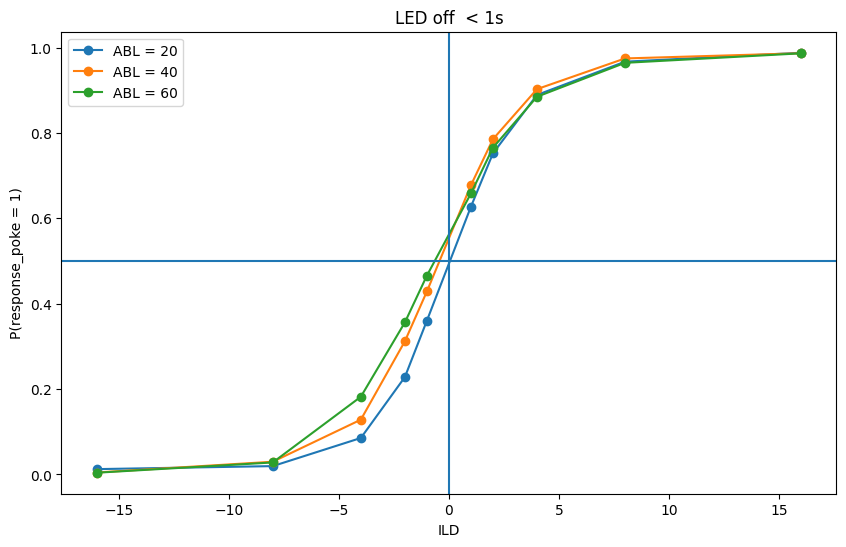

In [13]:
# Group by ABL and ILD, compute probability of response_poke == 1
grouped_response_1 = df_0_valid_less_than_1.groupby(['ABL', 'ILD'])['response_poke'].apply(lambda x: (x == 1).mean()).reset_index(name='prob_response_1')

# Plotting
plt.figure(figsize=(10, 6))
for abl in grouped_response_1['ABL'].unique():
    subset = grouped_response_1[grouped_response_1['ABL'] == abl]
    plt.plot(subset['ILD'], subset['prob_response_1'], marker='o', label=f'ABL = {abl}')

plt.xlabel('ILD')
plt.ylabel('P(response_poke = 1)')
plt.title('LED off  < 1s')
plt.legend()

plt.axvline(0)
plt.axhline(0.5)

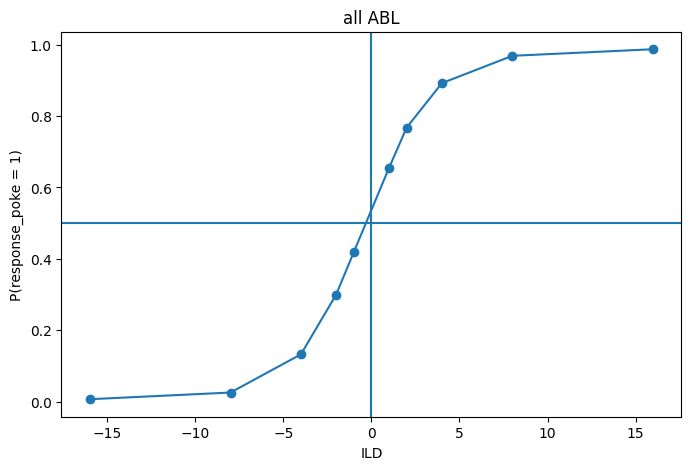

In [14]:
# Group by ILD only, compute overall probability of response_poke == 1
overall_response_1 = df_0_valid_less_than_1.groupby('ILD')['response_poke'].apply(lambda x: (x == 1).mean()).reset_index(name='prob_response_1')

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(overall_response_1['ILD'], overall_response_1['prob_response_1'], marker='o', linestyle='-')
plt.xlabel('ILD')
plt.ylabel('P(response_poke = 1)')
plt.title('all ABL')
plt.axvline(0)
plt.axhline(0.5)

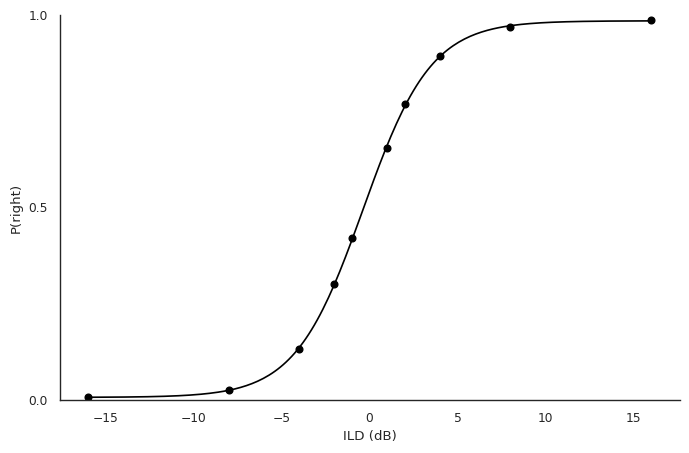

In [25]:
# Fit sigmoidal curve to the psychometric
from scipy.optimize import curve_fit

def sigmoid(x, x0, k, ymin, ymax):
    return ymin + (ymax - ymin) / (1 + np.exp(-k * (x - x0)))

p0 = [0, 1, 0, 1]
popt, _ = curve_fit(sigmoid, overall_response_1['ILD'], overall_response_1['prob_response_1'], p0=p0)

# Plotting
plt.figure(figsize=(8, 5))
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
x_smooth = np.linspace(min(overall_response_1['ILD']), max(overall_response_1['ILD']), 200)
plt.plot(x_smooth, sigmoid(x_smooth, *popt), color='black', label='Sigmoid fit')
plt.plot(overall_response_1['ILD'], overall_response_1['prob_response_1'], marker='o', linestyle='None', color='black', label='Data')
plt.xlabel('ILD (dB)')
plt.ylabel('P(right)')
# plt.title('All ABL')
# plt.axvline(0, color='black', linestyle='--')
# plt.axhline(0.5, color='black', linestyle='--')
sns.despine(top=True, right=True)
plt.ylim(0, 1)
plt.yticks([0,0.5, 1]);
# plt.legend();

# Aborts cenered on LED on set

In [6]:
abort_wrt_led_onset_led_on = []
for idx, row in tqdm(df_1.iterrows(), total=len(df_1)):
    # if row['timed_fix'] > 0.3:
        if row['timed_fix'] < row['intended_fix'] and row['timed_fix'] > row['LED_onset_time']:
            abort_wrt_led_onset_led_on.append(row['timed_fix'] - row['LED_onset_time'])

abort_wrt_led_onset_led_off = []
for idx, row in tqdm(df_0.iterrows(), total=len(df_0)):
    # if row['timed_fix'] > 0.3:
        if row['timed_fix'] < row['intended_fix'] and row['timed_fix'] > row['LED_onset_time']:
            abort_wrt_led_onset_led_off.append(row['timed_fix'] - row['LED_onset_time'])

100%|██████████| 66226/66226 [00:00<00:00, 115549.50it/s]


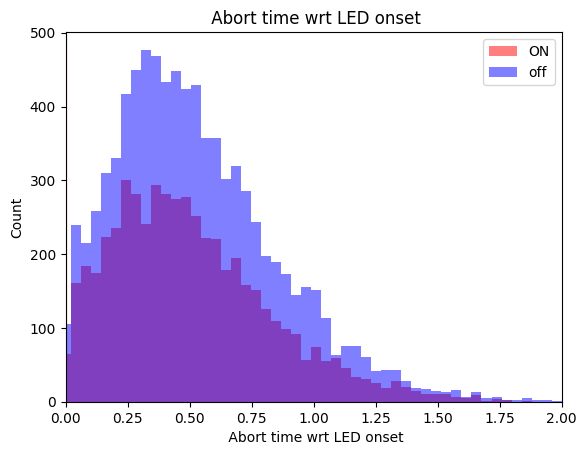

In [7]:
bins = np.linspace(-2,2, 100)
plt.hist(abort_wrt_led_onset_led_on, bins=bins, alpha=0.5, color='r', label='ON')
plt.hist(abort_wrt_led_onset_led_off, bins=bins, alpha=0.5, label='off', color='b')
plt.xlabel(' Abort time wrt LED onset')
plt.ylabel('Count')
plt.title(' Abort time wrt LED onset')
plt.axvline(x=0, color='r');
plt.legend();
plt.xlim(0, 2);

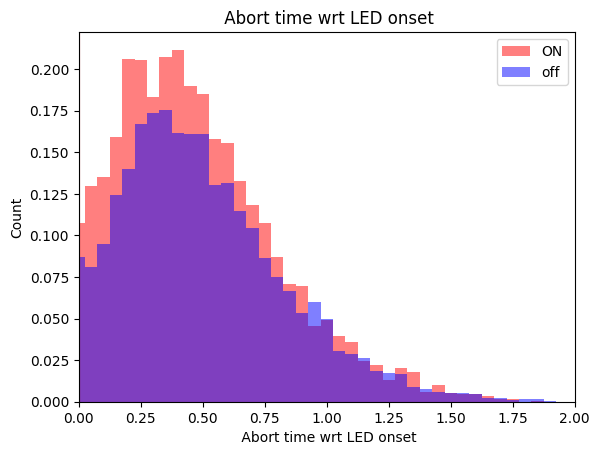

In [8]:
bins = np.arange(-2,2,0.05)
# normalize wrt total num of trials
on_hist, _ = np.histogram(abort_wrt_led_onset_led_on, bins=bins, density=True)
off_hist, _ = np.histogram(abort_wrt_led_onset_led_off, bins=bins, density=True)

on_hist = on_hist * len(abort_wrt_led_onset_led_on)/len(df_1)
off_hist =  off_hist * len(abort_wrt_led_onset_led_off)/len(df_0)

plt.bar(bins[:-1], on_hist, width=0.05, alpha=0.5, color='r', label='ON')
plt.bar(bins[:-1], off_hist, width=0.05, alpha=0.5, label='off', color='b')

plt.xlabel(' Abort time wrt LED onset')
plt.ylabel('Count')
plt.title(' Abort time wrt LED onset')
plt.axvline(x=0, color='r');
plt.legend();
plt.xlim(0, 2);

In [9]:
# In df, find unique LED_onset_time
LED_onset_time_arr = df['LED_onset_time'].unique()

diff_btn_aborts = []

for t in LED_onset_time_arr:
    
    # find rows with LED_onset_time in df_1
    df_1_t = df_1[ df_1['LED_onset_time'].isin([t]) ]
    df_0_t = df_0[ df_0['LED_onset_time'].isin([t]) ]

    # df_1_t timed_fix where timed_fix < intended_fix
    df_1_t_aborts = df_1_t[ df_1_t['timed_fix'] < df_1_t['intended_fix'] ]
    df_0_t_aborts = df_0_t[ df_0_t['timed_fix'] < df_0_t['intended_fix'] ]

    #  truncate t > 0.3
    df_1_t_aborts = df_1_t_aborts[ df_1_t_aborts['timed_fix'] > 0.3 ]
    df_0_t_aborts = df_0_t_aborts[ df_0_t_aborts['timed_fix'] > 0.3 ]

    # aborts wrt LED onset
    aborts_wrt_LED_onset_1 = df_1_t_aborts['timed_fix'] - df_1_t_aborts['LED_onset_time']
    aborts_wrt_LED_onset_0 = df_0_t_aborts['timed_fix'] - df_0_t_aborts['LED_onset_time']

    # mean of on - mean of off
    mean_aborts_1 = np.mean( aborts_wrt_LED_onset_1 )
    mean_aborts_0 = np.mean( aborts_wrt_LED_onset_0 )

    # if any of them are nan, skip
    if np.isnan(mean_aborts_1) or np.isnan(mean_aborts_0):
        continue

    diff_btn_aborts.append( mean_aborts_1 - mean_aborts_0 )

    

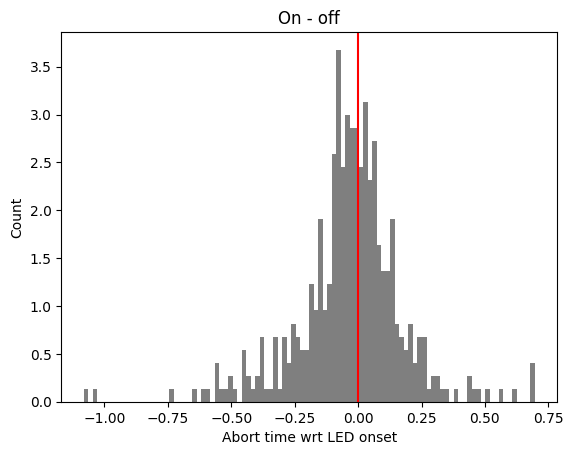

In [10]:
plt.hist(diff_btn_aborts, bins=100, alpha=0.5, color='k', density=True)
plt.title('On - off')
plt.xlabel('Abort time wrt LED onset')
plt.ylabel('Count')
plt.axvline(x=0, color='r');

# Pscyhometric funcs

In [11]:
# correct and trials dict init
num_RHS_LED_on_dict = {}
num_trials_LED_on_dict = {}

num_RHS_LED_off_dict = {}
num_trials_LED_off_dict = {}

for ABL in ABL_arr:
    num_RHS_LED_on_dict[ABL] = np.zeros_like(ILD_arr)
    num_trials_LED_on_dict[ABL] = np.zeros_like(ILD_arr)

    num_RHS_LED_off_dict[ABL] = np.zeros_like(ILD_arr)
    num_trials_LED_off_dict[ABL] = np.zeros_like(ILD_arr)


# iteratre for each row of df
for index, row in tqdm(df.iterrows()):
    ABL = row['ABL']
    ILD = row['ILD']
    response_poke = row['response_poke']
    LED_trial = row['LED_trial']

    if np.isnan(response_poke):
        continue
    if LED_trial == 1:
        num_trials_LED_on_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if response_poke == 1:
            num_RHS_LED_on_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
    else:
        num_trials_LED_off_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1
        if response_poke == 1:
            num_RHS_LED_off_dict[ABL][int(np.where(ILD_arr == ILD)[0][0])] += 1

100251it [00:01, 81301.46it/s]


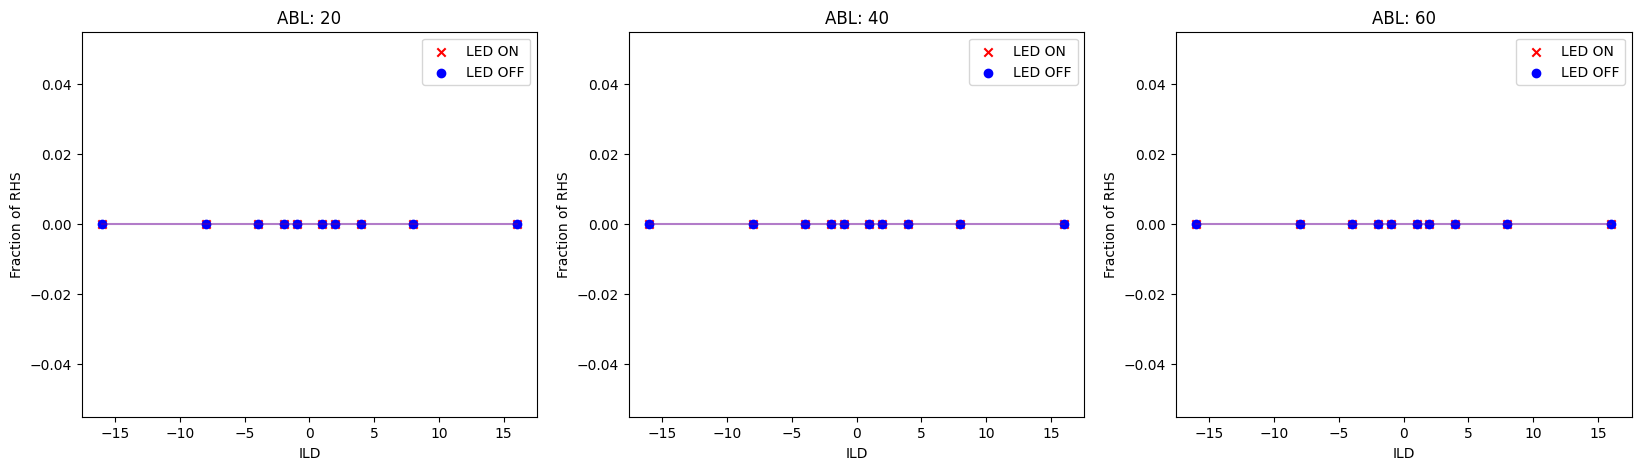

In [12]:
# for each ABL plot fraction of correct 
plt.figure(figsize=(20,5))
for i, ABL in enumerate(ABL_arr):
    plt.subplot(1, len(ABL_arr), i+1)
    plt.scatter(ILD_arr, num_RHS_LED_on_dict[ABL]/num_trials_LED_on_dict[ABL], label='LED ON', color='red', marker='x')
    plt.plot(ILD_arr, num_RHS_LED_on_dict[ABL]/num_trials_LED_on_dict[ABL], color='red', alpha=0.3)

    plt.scatter(ILD_arr, num_RHS_LED_off_dict[ABL]/num_trials_LED_off_dict[ABL], label='LED OFF', color='b', marker='o')
    plt.plot(ILD_arr, num_RHS_LED_off_dict[ABL]/num_trials_LED_off_dict[ABL], color='b', alpha=0.3)
    plt.xlabel('ILD'); plt.ylabel('Fraction of RHS'); plt.title('ABL: '+str(ABL));
    plt.legend()


# Percentiles

In [13]:
rt_LED_on_per_ABL_dict = {}
rt_LED_off_per_ABL_dict = {}

for ABL in ABL_arr:
    rt_LED_on_per_ABL_dict[ABL] = {ILD:[] for ILD in ILD_arr}
    rt_LED_off_per_ABL_dict[ABL] = {ILD:[] for ILD in ILD_arr}


for index, row in tqdm(df.iterrows()):
    ABL = row['ABL']
    ILD = row['ILD']
    
    intended_fix = row['intended_fix']
    timed_fix = row['timed_fix']

    LED_trial = row['LED_trial']

    if np.isnan(intended_fix) or np.isnan(timed_fix):
        continue

    rt = timed_fix - intended_fix        


    if LED_trial == 1:
        rt_LED_on_per_ABL_dict[ABL][ILD].append(rt)
    else:
        rt_LED_off_per_ABL_dict[ABL][ILD].append(rt)

100251it [00:01, 89583.46it/s]


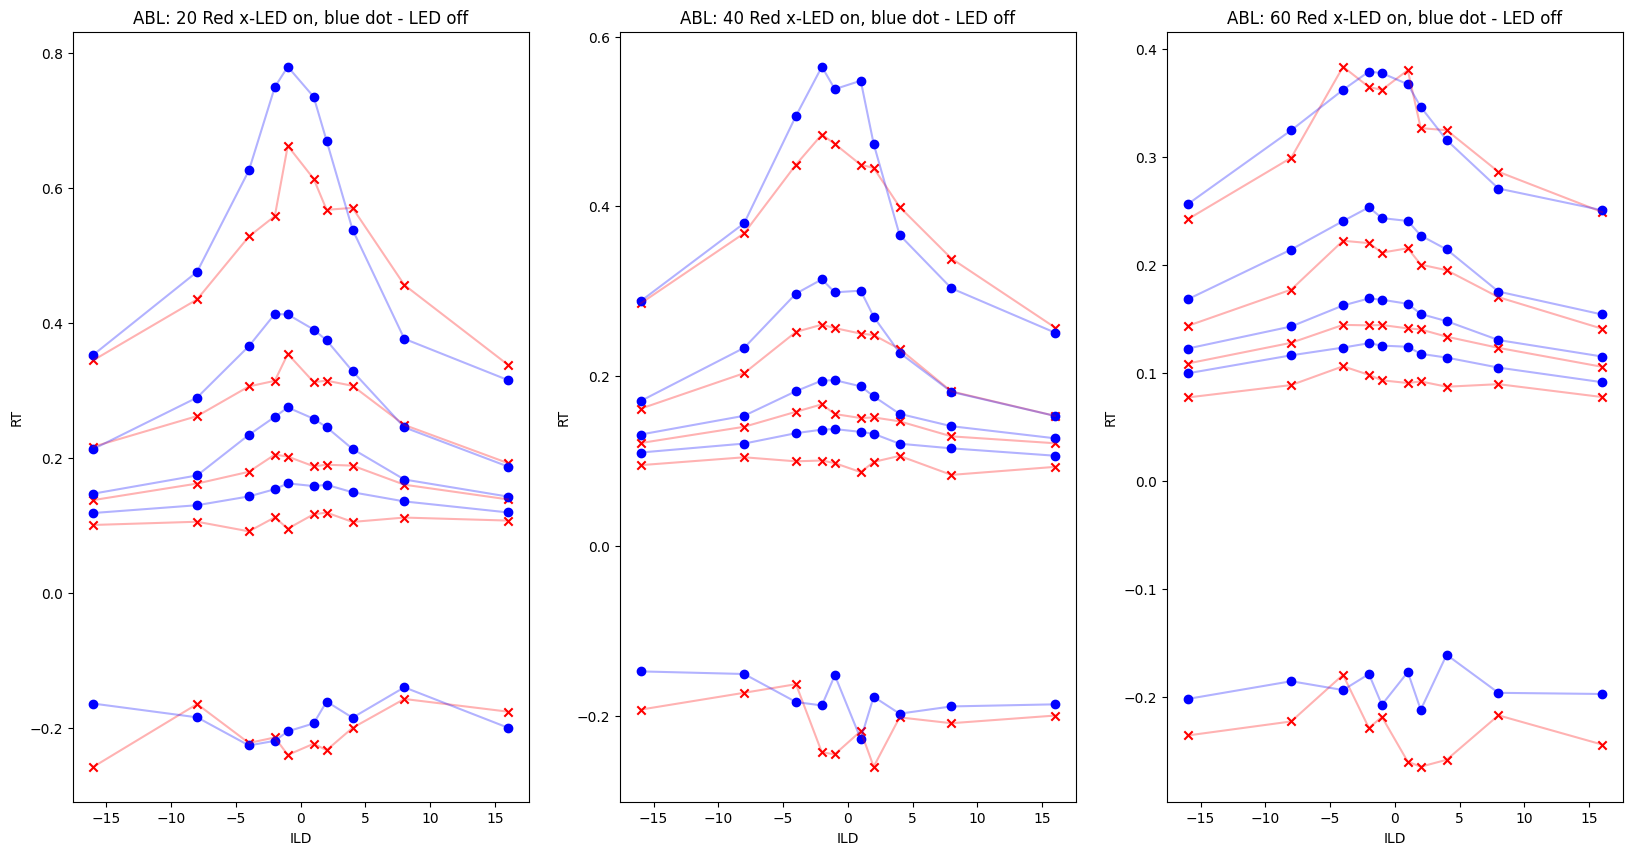

In [14]:
percentiles = [10, 30, 50, 70, 90]
plt.figure(figsize=(20,10))
for a, ABL in enumerate(ABL_arr):
    percentiles_LED_on = np.zeros((len(ILD_arr), len(percentiles)))
    percentiles_LED_off = np.zeros((len(ILD_arr), len(percentiles)))

    for i, ILD in enumerate(ILD_arr):
        if len(rt_LED_on_per_ABL_dict[ABL][ILD]) == 0:
            percentiles_LED_on[i] = np.nan
            print(f'ILD = {ILD} and ABL = {ABL} has no LED on trials')
        else:
            percentiles_LED_on[i] = np.percentile(rt_LED_on_per_ABL_dict[ABL][ILD], percentiles)

        
        if len(rt_LED_off_per_ABL_dict[ABL][ILD]) == 0:
            percentiles_LED_off[i] = np.nan
            print(f'ILD = {ILD} and ABL = {ABL} has no LED off trials')
        else:
            percentiles_LED_off[i] = np.percentile(rt_LED_off_per_ABL_dict[ABL][ILD], percentiles)

    plt.subplot(1, len(ABL_arr), a+1)
    for j, percentile in enumerate(percentiles):
        plt.scatter(ILD_arr, percentiles_LED_on[:,j], color='red', marker='x', label='LED on')
        plt.plot(ILD_arr, percentiles_LED_on[:,j], color='red',alpha=0.3)

        plt.scatter(ILD_arr, percentiles_LED_off[:,j], color='blue', marker='o', label='LED off')   
        plt.plot(ILD_arr, percentiles_LED_off[:,j], color='blue', alpha=0.3)
    
    plt.title(f'ABL: {str(ABL)} Red x-LED on, blue dot - LED off'); plt.xlabel('ILD'); plt.ylabel('RT'); 
    

# RTD disrributions

In [15]:
led_on_after_light = df_1[ (df_1['timed_fix'] > df_1['LED_onset_time']) ]
led_on_rt_wrt_stim = (led_on_after_light['timed_fix'] - led_on_after_light['intended_fix']).values

led_off_after_light = df_0[ (df_0['timed_fix'] > df_0['LED_onset_time']) ]
led_off_rt_wrt_stim = (led_off_after_light['timed_fix'] - led_off_after_light['intended_fix']).values

 num of off aborts: 8552/62878 = 0.13600941505773084
num of on aborts: 5319/30471 = 0.17455941715073348


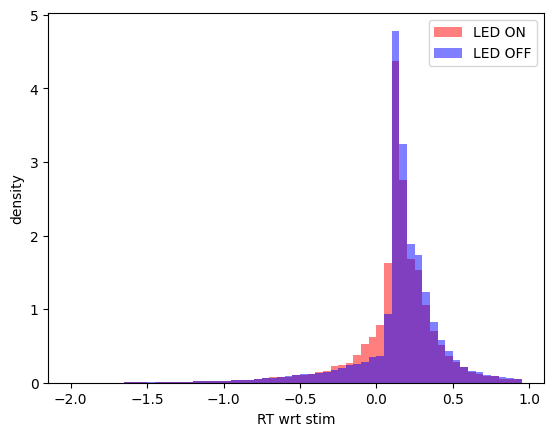

In [16]:
plt.hist(led_on_rt_wrt_stim, bins=np.arange(-2, 1, 0.05), alpha=0.5, color='r', label='LED ON', density=True)
plt.hist(led_off_rt_wrt_stim, bins=np.arange(-2, 1, 0.05), alpha=0.5, color='b', label='LED OFF', density=True)
plt.xlabel('RT wrt stim')
plt.ylabel('density')
plt.legend();

# num of led_off_after_light < 0
print(f' num of off aborts: {np.sum(led_off_rt_wrt_stim < 0)}/{len(led_off_rt_wrt_stim)} = {np.sum(led_off_rt_wrt_stim < 0)/len(led_off_rt_wrt_stim)}')
print(f'num of on aborts: {np.sum(led_on_rt_wrt_stim < 0)}/{len(led_on_rt_wrt_stim)} = {np.sum(led_on_rt_wrt_stim < 0)/len(led_on_rt_wrt_stim)}')

# Chronometric functions

In [17]:
led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

In [18]:
# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])

In [19]:
# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

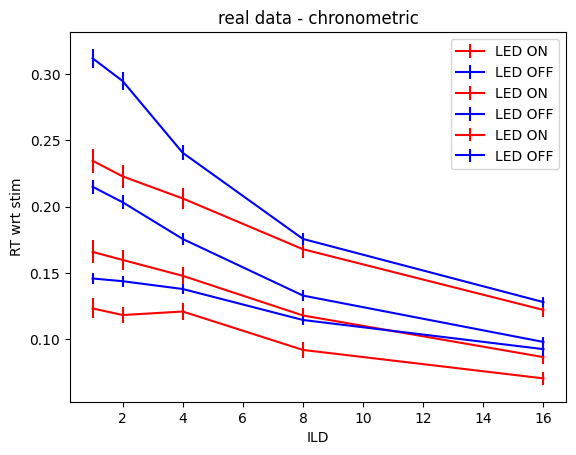

In [20]:
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric')
    

# Chronometric functions without aborts

In [26]:
led_on_abl_ild = {}
led_off_abl_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_abl_ild[(ABL, ILD)] = []
        led_off_abl_ild[(ABL, ILD)] = []

# ON
for _, row in df_1.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_on_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])
    
# OFF
for _, row in df_0.iterrows():
    ABL = row['ABL']
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_abl_ild[(ABL, abs_ILD)].append(row['timed_fix'] - row['intended_fix'])


# on and off mean and std
led_on_mean = {}
led_on_std_err = {}

led_off_mean = {}
led_off_std_err = {}

for ABL in ABL_arr:
    for ILD in positive_ILD_arr:
        led_on_mean[(ABL, ILD)] = np.mean(led_on_abl_ild[(ABL, ILD)])
        led_on_std_err[(ABL, ILD)] = np.std(led_on_abl_ild[(ABL, ILD)])/np.sqrt(len(led_on_abl_ild[(ABL, ILD)]))

        led_off_mean[(ABL, ILD)] = np.mean(led_off_abl_ild[(ABL, ILD)])
        led_off_std_err[(ABL, ILD)] = np.std(led_off_abl_ild[(ABL, ILD)])/np.sqrt(len(led_off_abl_ild[(ABL, ILD)]))

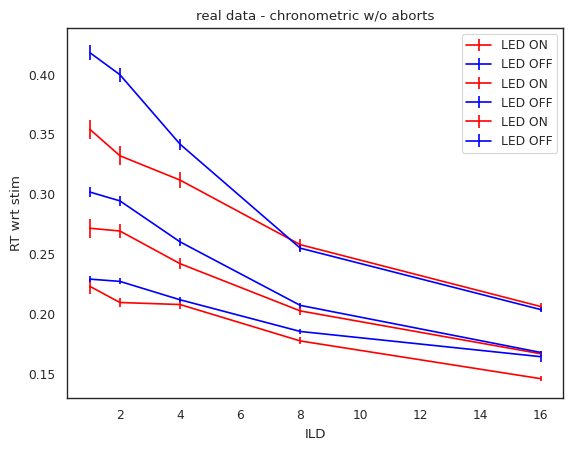

In [27]:
for ABL in ABL_arr:
    # mean and err vs positive ILD
    plt.errorbar(positive_ILD_arr, [led_on_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_on_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED ON', color='red')
    plt.errorbar(positive_ILD_arr, [led_off_mean[(ABL, ILD)] for ILD in positive_ILD_arr], yerr=[led_off_std_err[(ABL, ILD)] for ILD in positive_ILD_arr], label='LED OFF', color='blue')

    plt.xlabel('ILD')
    plt.ylabel('RT wrt stim')
    plt.legend()
    plt.title('real data - chronometric w/o aborts')
    

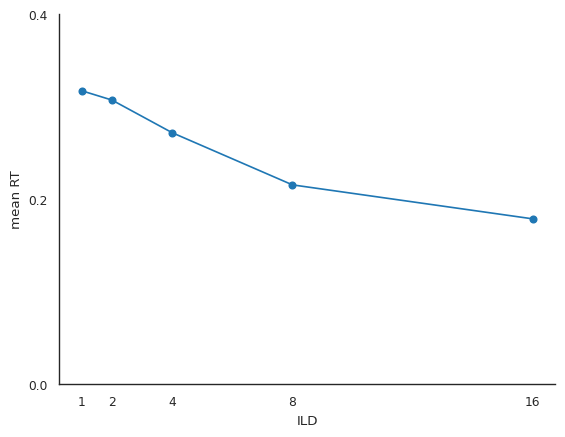

In [ ]:
led_off_ild = {}

positive_ILD_arr = ILD_arr[ILD_arr > 0]

for ILD in positive_ILD_arr:
    led_off_ild[ILD] = []

# OFF
for _, row in df_0.iterrows():
    ILD = row['ILD']
    abs_ILD = np.abs(ILD)

    if row['timed_fix'] > row['LED_onset_time'] and row['timed_fix'] > row['intended_fix']: # if after onset time
        led_off_ild[abs_ILD].append(row['timed_fix'] - row['intended_fix'])

# off mean and std err
led_off_mean = {}
led_off_std_err = {}

for ILD in positive_ILD_arr:
    led_off_mean[ILD] = np.mean(led_off_ild[ILD])
    led_off_std_err[ILD] = np.std(led_off_ild[ILD])/np.sqrt(len(led_off_ild[ILD]))

# mean and err vs positive ILD
fig, ax = plt.subplots()
ax.errorbar(positive_ILD_arr, [led_off_mean[ILD] for ILD in positive_ILD_arr], 
         yerr=[led_off_std_err[ILD] for ILD in positive_ILD_arr], 
         label='All ABLs', marker='o')

ax.set_xlabel('ILD')
ax.set_ylabel('mean RT')
# ax.legend()
# ax.set_title('LED OFF chronometric curve (all ABLs)')
ax.set_xticks([1, 2, 4, 8, 16])
ax.set_yticks([0, 0.2, 0.4])
ax.set_ylim(0, 0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tachometric curves

In [28]:
bin_width = 0.05
t_bins = np.arange(0, 10, bin_width)

total_and_up_counts_dict_on = {}
total_and_up_counts_dict_off = {}

for ABL in ABL_arr:
    for ILD in ILD_arr:
        total_and_up_counts_dict_on[(ABL, ILD)] = {}
        total_and_up_counts_dict_on[(ABL, ILD)]['total'] = np.zeros_like(t_bins)
        total_and_up_counts_dict_on[(ABL, ILD)]['up'] = np.zeros_like(t_bins)
        
        total_and_up_counts_dict_off[(ABL, ILD)] = {}
        total_and_up_counts_dict_off[(ABL, ILD)]['total'] = np.zeros_like(t_bins)
        total_and_up_counts_dict_off[(ABL, ILD)]['up'] = np.zeros_like(t_bins)


for _, row in df.iterrows():
    ABL = row['ABL']; ILD = row['ILD']

    if row['LED_trial'] == 1:
        if row['timed_fix'] > row['intended_fix']:
            rt_wrt_stim = row['timed_fix'] - row['intended_fix']
            rt_wrt_stim_idx = int(rt_wrt_stim // bin_width)

            total_and_up_counts_dict_on[(ABL, ILD)]['total'][rt_wrt_stim_idx] += 1
            if row['response_poke'] == 3:
                total_and_up_counts_dict_on[(ABL, ILD)]['up'][rt_wrt_stim_idx] += 1

    elif row['LED_trial'] == 0:
        if row['timed_fix'] > row['intended_fix']:
            rt_wrt_stim = row['timed_fix'] - row['intended_fix']
            rt_wrt_stim_idx = int(rt_wrt_stim // bin_width)

            total_and_up_counts_dict_off[(ABL, ILD)]['total'][rt_wrt_stim_idx] += 1
            if row['response_poke'] == 3:
                total_and_up_counts_dict_off[(ABL, ILD)]['up'][rt_wrt_stim_idx] += 1
 

/tmp/ipykernel_60439/3380099281.py:14: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_bins, total_and_up_counts_dict_on[(ABL, ILD)]['up']/total_and_up_counts_dict_on[(ABL, ILD)]['total'],  color='red', label='LED ON')
/tmp/ipykernel_60439/3380099281.py:15: RuntimeWarning: invalid value encountered in divide
  plt.plot(t_bins, total_and_up_counts_dict_off[(ABL, ILD)]['up']/total_and_up_counts_dict_off[(ABL, ILD)]['total'], color='blue', label='LED off')


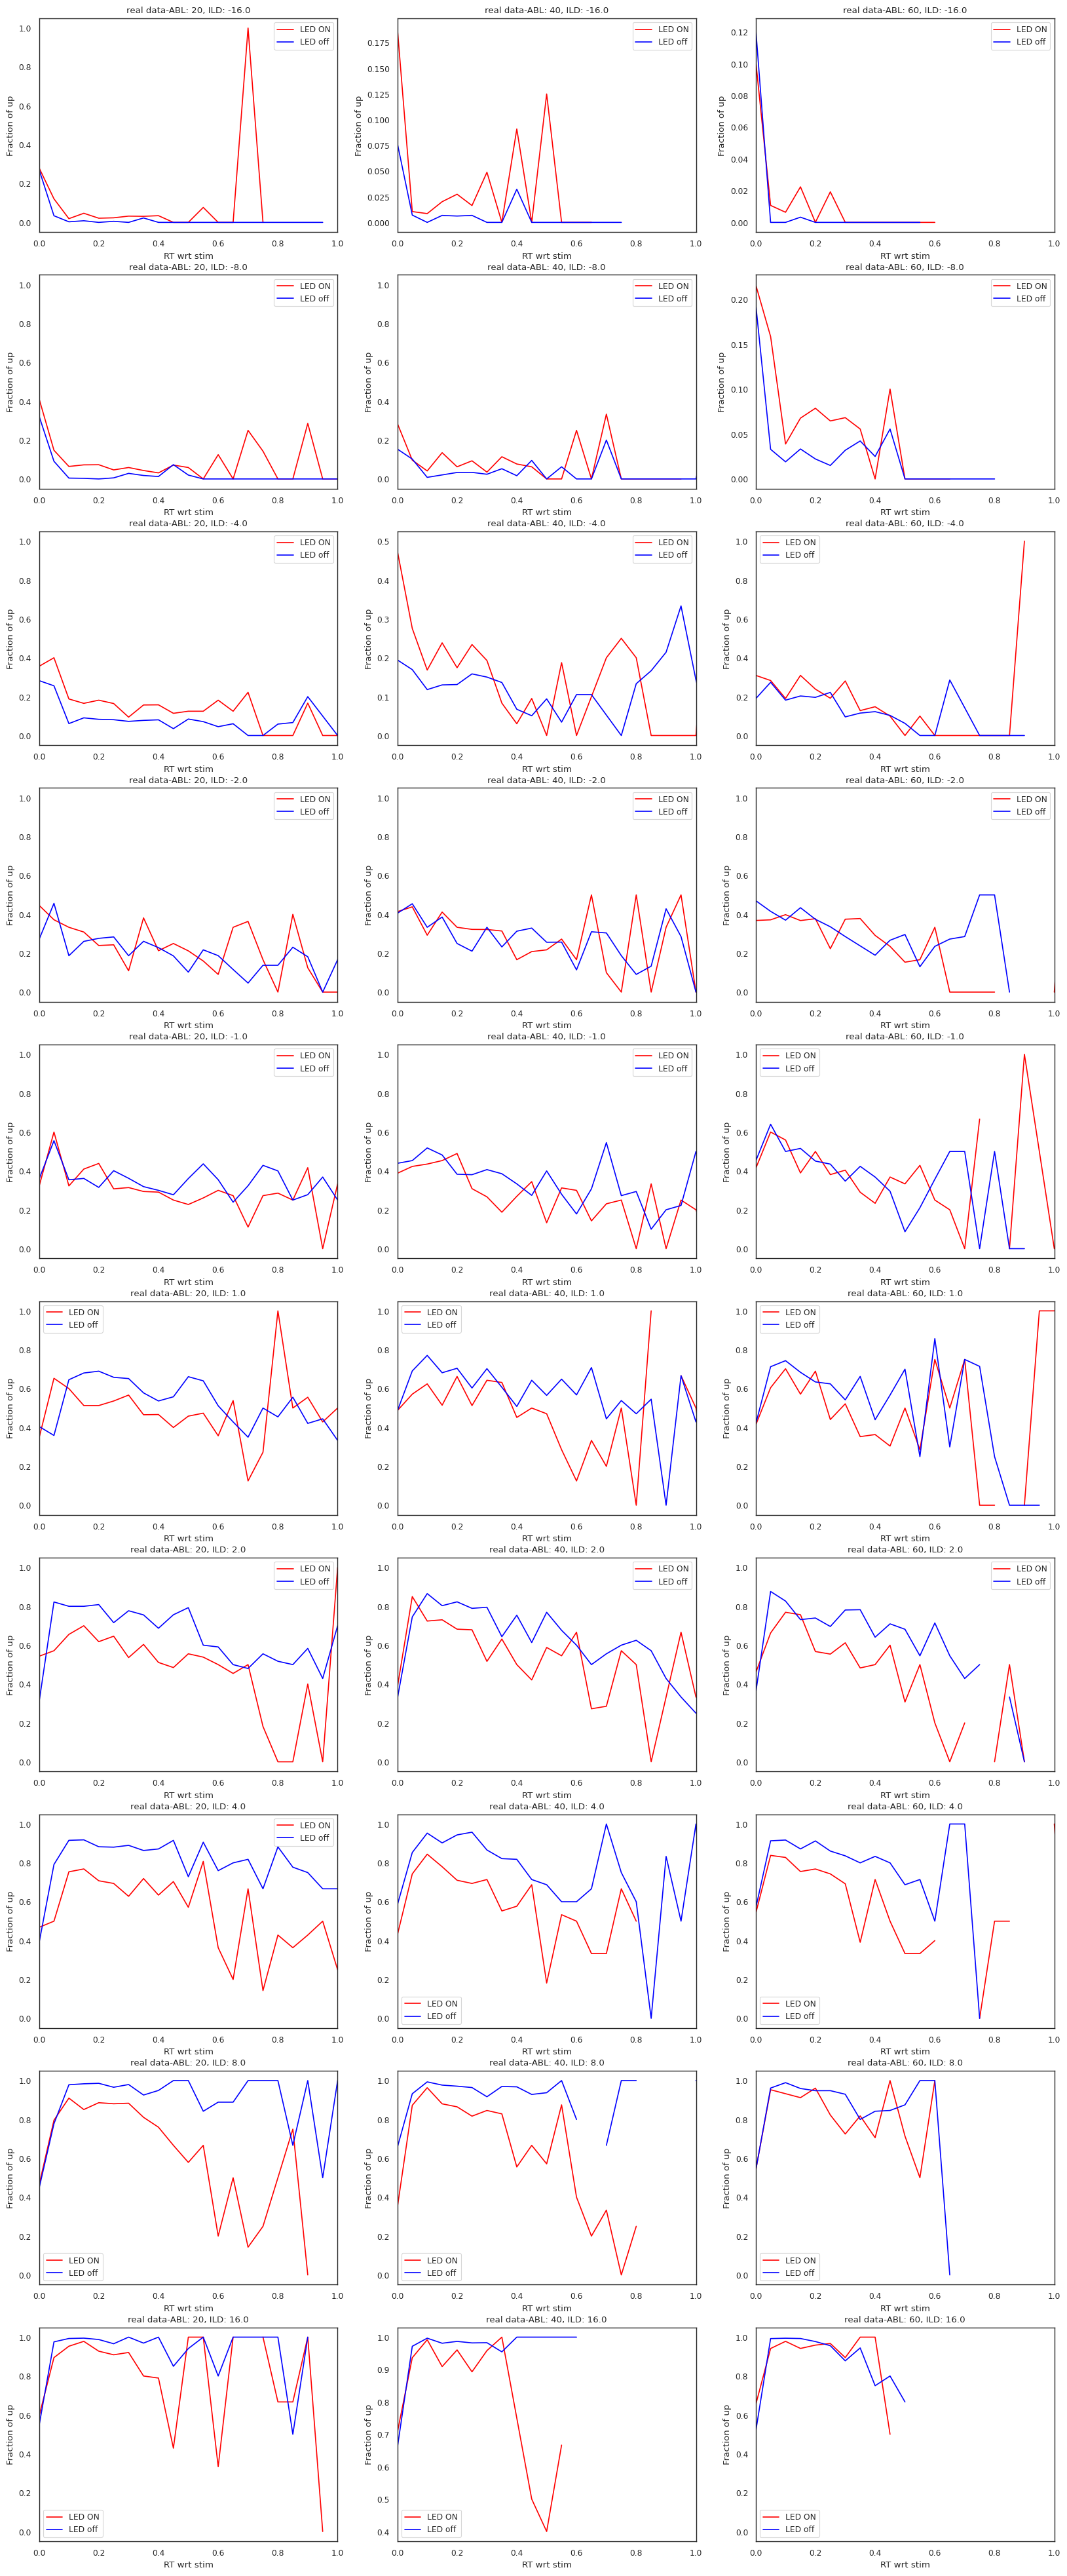

In [29]:
plt.figure(figsize=(20,50))
a = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:

        plt.subplot(len(ILD_arr), len(ABL_arr),  a)

        if np.sum(total_and_up_counts_dict_on[(ABL, ILD)]['total']) == 0:
            continue

        if np.sum(total_and_up_counts_dict_off[(ABL, ILD)]['total']) == 0:
            continue
    
        plt.plot(t_bins, total_and_up_counts_dict_on[(ABL, ILD)]['up']/total_and_up_counts_dict_on[(ABL, ILD)]['total'],  color='red', label='LED ON')
        plt.plot(t_bins, total_and_up_counts_dict_off[(ABL, ILD)]['up']/total_and_up_counts_dict_off[(ABL, ILD)]['total'], color='blue', label='LED off')
        plt.xlabel('RT wrt stim')
        plt.ylabel('Fraction of up')
        plt.title(f'real data-ABL: {ABL}, ILD: {ILD}')
        plt.legend()
        plt.xlim(0, 1)
    
        a += 1

# grand mean of all on and off rt

In [25]:
df_1_non_aborts_after_led = df_1[ (df_1['timed_fix'] > df_1['intended_fix'])  & (df_1['timed_fix'] > df_1['LED_onset_time']) ]
df_1_rt_wrt_stim = df_1_non_aborts_after_led['timed_fix'] - df_1_non_aborts_after_led['intended_fix']

df_0_non_aborts_after_led = df_0[ (df_0['timed_fix'] > df_0['intended_fix']) & (df_0['timed_fix'] > df_0['LED_onset_time']) ]
df_0_rt_wrt_stim = df_0_non_aborts_after_led['timed_fix'] - df_0_non_aborts_after_led['intended_fix']


In [26]:
df_1_rt_wrt_stim_mean = (df_1_rt_wrt_stim.values).mean()

df_0_rt_wrt_stim_mean = (df_0_rt_wrt_stim.values).mean()


print('df_1_rt_wrt_stim_mean:', df_1_rt_wrt_stim_mean)
print('df_0_rt_wrt_stim_mean:', df_0_rt_wrt_stim_mean)

print('var of df_1_rt_wrt_stim:', (df_1_rt_wrt_stim.values).var())
print('var of df_0_rt_wrt_stim:', (df_0_rt_wrt_stim.values).var())

print(100*(df_1_rt_wrt_stim_mean - df_0_rt_wrt_stim_mean)/df_1_rt_wrt_stim_mean)

df_1_rt_wrt_stim_mean: 0.23886783561087044
df_0_rt_wrt_stim_mean: 0.2581639750557215
var of df_1_rt_wrt_stim: 0.051672891291802595
var of df_0_rt_wrt_stim: 0.05428117783283372
-8.078165649847293


Text(0.5, 1.0, 'real data - rt wrt stim')

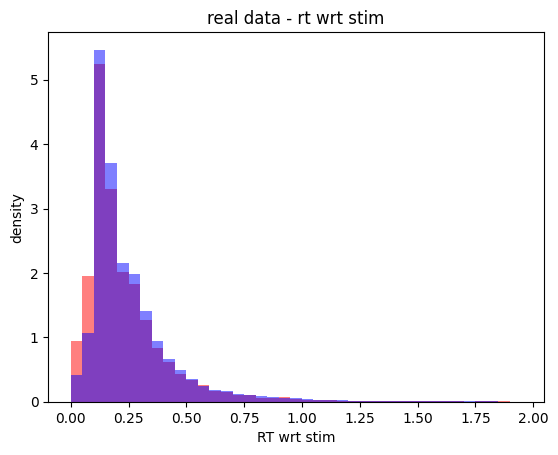

In [27]:
plt.hist(df_1_rt_wrt_stim.values, bins=np.arange(0, 2, 0.05), alpha=0.5, color='r', label='LED ON', density=True)
plt.hist(df_0_rt_wrt_stim.values, bins=np.arange(0, 2, 0.05), alpha=0.5, color='b', label='LED OFF', density=True)
plt.xlabel('RT wrt stim')
plt.ylabel('density')
plt.title('real data - rt wrt stim')

([<matplotlib.axis.XTick at 0x7b58d59cb260>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

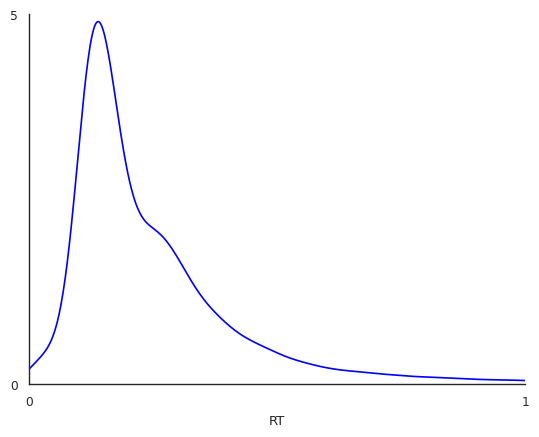

In [50]:
from scipy.stats import gaussian_kde

# Fit Gaussian KDE to the data
kde = gaussian_kde(df_0_rt_wrt_stim.values)

# Create evaluation points
x_grid = np.linspace(0, 2, 1000)

# Plot the KDE
plt.plot(x_grid, kde(x_grid), color='b', label='LED OFF')
plt.xlabel('RT')
# plt.ylabel('density')
# plt.title('real data - rt wrt stim (KDE)')

# Remove top and right margins
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set axis limits
plt.xlim(0, 0.75)
plt.ylim(0, 5)

# Set yticks
plt.yticks([0, 5])

# set xticks
plt.xticks([0, 1])

# grand accuracy

In [28]:
df_1_non_aborts_after_led = df_1[ (df_1['timed_fix'] > df_1['intended_fix'])  & (df_1['timed_fix'] > df_1['LED_onset_time']) ]
n_correct_1 = 0; n_total_1 = 0
for _, row in df_1_non_aborts_after_led.iterrows():
    n_total_1 += 1
    if (row['ILD'] > 0 and row['response_poke'] == 3) or (row['ILD'] < 0 and row['response_poke'] == 2):
        n_correct_1 += 1


df_0_non_aborts_after_led = df_0[ (df_0['timed_fix'] > df_0['intended_fix']) & (df_0['timed_fix'] > df_0['LED_onset_time']) ]

n_correct_0 = 0; n_total_0 = 0
for _, row in df_0_non_aborts_after_led.iterrows():
    n_total_0 += 1
    if (row['ILD'] > 0 and row['response_poke'] == 3) or (row['ILD'] < 0 and row['response_poke'] == 2):
        n_correct_0 += 1

In [29]:
on_acc = n_correct_1/n_total_1
off_acc = n_correct_0/n_total_0

print(f'on correct: {n_correct_1}/{n_total_1} = {on_acc}')
print(f'off correct: {n_correct_0}/{n_total_0} = {off_acc}')

print(f'rel on - off/ off= {on_acc - off_acc}/ {off_acc} = {100*(on_acc - off_acc)/off_acc}')

on correct: 18897/25152 = 0.7513120229007634
off correct: 44827/54326 = 0.8251481795088907
rel on - off/ off= -0.07383615660812737/ 0.8251481795088907 = -8.948229959384138


# stim and led time distr

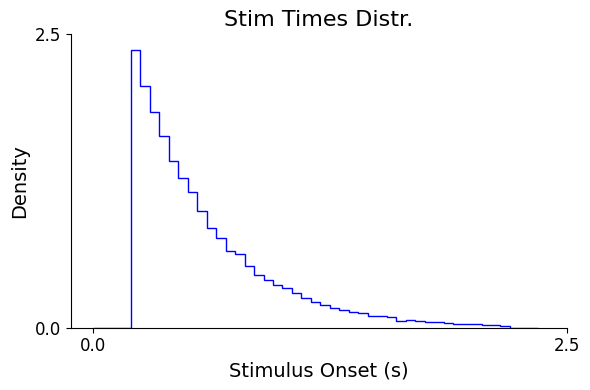

In [36]:
stim_times = df['intended_fix']

bins = np.arange(0, 2.4, 0.05)
plt.figure(figsize=(6, 4))

plt.hist(stim_times, bins=bins, color='b', density=True, histtype='step')

ax = plt.gca()

ax.set_title('Stim Times Distr.', fontsize=16)
ax.set_xlabel('Stimulus Onset (s)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Only 2 x-ticks at the extreme values
xmin, xmax = ax.get_xlim()
ax.set_xticks([0, 2.5])

# Only 2 y-ticks at 0 and max
ymin, ymax = ax.get_ylim()
ax.set_yticks([0, 2.5])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


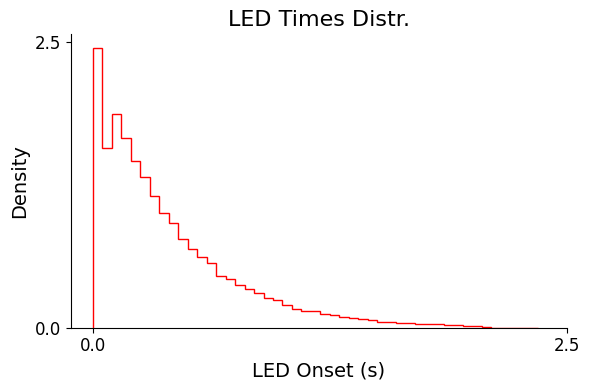

In [38]:
led_times =  df['intended_fix'] - df['LED_onset_time']

bins = np.arange(0, 2.4, 0.05)
plt.figure(figsize=(6, 4))

plt.hist(led_times, bins=bins, color='r', density=True, histtype='step')

ax = plt.gca()

ax.set_title('LED Times Distr.', fontsize=16)
ax.set_xlabel('LED Onset (s)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Only 2 x-ticks at the extreme values
xmin, xmax = ax.get_xlim()
ax.set_xticks([0, 2.5])

# Only 2 y-ticks at 0 and max
ymin, ymax = ax.get_ylim()
ax.set_yticks([0, 2.5])

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
